In [1]:
import os
import sys
import math
import scipy as scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
pd.set_option('display.max_columns',100)

### Project Objectives
Provider Fraud is one of the biggest problems facing Medicare. According to the government, the total Medicare spending increased exponentially due to frauds in Medicare claims. Healthcare fraud is an organized crime which involves peers of providers, physicians, beneficiaries acting together to make fraud claims.

Rigorous analysis of Medicare data has yielded many physicians who indulge in fraud. They adopt ways in which an ambiguous diagnosis code is used to adopt costliest procedures and drugs. Insurance companies are the most vulnerable institutions impacted due to these bad practices. Due to this reason, insurance companies increased their insurance premiums and as result healthcare is becoming costly matter day by day.

Healthcare fraud and abuse take many forms. Some of the most common types of frauds by providers are:

a) Billing for services that were not provided.

b) Duplicate submission of a claim for the same service.

c) Misrepresenting the service provided.

d) Charging for a more complex or expensive service than was actually provided.

e) Billing for a covered service when the service actually provided was not covered.

Problem Statement
The goal of this project is to " predict the potentially fraudulent providers " based on the claims filed by them.along with this, we will also discover important variables helpful in detecting the behaviour of potentially fraud providers. further, we will study fraudulent patterns in the provider's claims to understand the future behaviour of providers.

Introduction to the Dataset
For the purpose of this project, we are considering Inpatient claims, Outpatient claims and Beneficiary details of each provider. Lets s see their details

### Data loading

Data are loaded from the public github repository https://github.com/EY-Tech-Consulting-Denmark/Graphathon-ATP/tree/main/Data/raw_data

In [2]:
beneficiary = pd.read_csv("https://raw.githubusercontent.com/EY-Tech-Consulting-Denmark/Graphathon-ATP/main/Data/raw_data/Train_Beneficiarydata-1542865627584.csv")
inpatient = pd.read_csv("https://raw.githubusercontent.com/EY-Tech-Consulting-Denmark/Graphathon-ATP/main/Data/raw_data/Train_Inpatientdata-1542865627584.csv")
label = pd.read_csv("https://raw.githubusercontent.com/EY-Tech-Consulting-Denmark/Graphathon-ATP/main/Data/raw_data/Train-1542865627584.csv")

#### Label data
This is of list historical data about each provider in the overall dataset.  
This information will allow for detecting patterns that in the future will help to identify whether new, unfamiliar providers are potentially fraudulent or not.


In [3]:
label.head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


In [4]:
label.shape

(5410, 2)

PotentialFraud
No     4904
Yes     506
dtype: int64


<AxesSubplot:xlabel='PotentialFraud'>

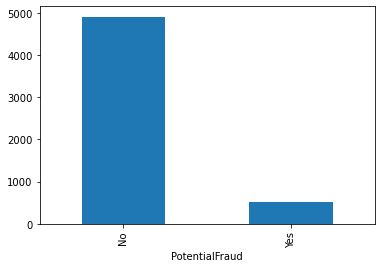

In [5]:
# class imballance check
label_overview = label.groupby("PotentialFraud").size()
print(label_overview)
label_overview.plot(kind='bar')

#### Beneficiary data

This data contains beneficiary KYC details like health conditions,regioregion they belong to etc.   
This dataset contains both patients that were admitted to the hospital and patients who were not admitted to the hospital.  
Data about patients who were not admitted to the hospital will be disregarded when merging with the other dataset.  


In [6]:
beneficiary.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,1,2,2,2,2,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,1,1,2,2,2,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,2,2,2,2,1,2,1,2,2,2,2,0,0,1790,1200


In [7]:
beneficiary.shape

(138556, 25)

In [8]:
beneficiary.describe()

,Gender,Race,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
count,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000
mean,1.570932,1.254511,25.666734,374.424745,11.907727,11.910145,1.667817,1.506322,1.687643,1.880041,1.762847,1.644476,1.398142,1.324143,1.725317,1.743180,1.920942,3660.346502,399.847296,1298.219348,377.718258
std,0.494945,0.717007,15.223443,266.277581,1.032332,0.936893,0.470998,0.499962,0.463456,0.324914,0.425339,0.478674,0.489517,0.468056,0.446356,0.436881,0.269831,9568.621827,956.175202,2493.901134,645.530187
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-8000.000000,0.000000,-70.000000,0.000000
25%,1.000000,1.000000,11.000000,141.000000,12.000000,12.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,170.000000,40.000000
50%,2.000000,1.000000,25.000000,340.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,570.000000,170.000000
75%,2.000000,1.000000,39.000000,570.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2280.000000,1068.000000,1500.000000,460.000000
max,2.000000,5.000000,54.000000,999.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,161470.000000,38272.000000,102960.000000,13840.000000


In [9]:
# missing values check
beneficiary.isna().sum()

BeneID                                  0
DOB                                     0
DOD                                137135
Gender                                  0
Race                                    0
RenalDiseaseIndicator                   0
State                                   0
County                                  0
NoOfMonths_PartACov                     0
NoOfMonths_PartBCov                     0
ChronicCond_Alzheimer                   0
ChronicCond_Heartfailure                0
ChronicCond_KidneyDisease               0
ChronicCond_Cancer                      0
ChronicCond_ObstrPulmonary              0
ChronicCond_Depression                  0
ChronicCond_Diabetes                    0
ChronicCond_IschemicHeart               0
ChronicCond_Osteoporasis                0
ChronicCond_rheumatoidarthritis         0
ChronicCond_stroke                      0
IPAnnualReimbursementAmt                0
IPAnnualDeductibleAmt                   0
OPAnnualReimbursementAmt          

Missing value of "DOD" column imply that the patients is still alive.  
The missing values will be replaced with '0' in the Feature engineering process later.  

#### Inpatient data
This data provides insights about the claims filed for those patients who are admitted in the hospitals. It also provides additional details like their admission and discharge dates and admit diagnosis code.  
Later will be this dataset merged with the Beneficiary data dataset presented above.  

In [10]:
inpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [11]:
inpatient.shape

(40474, 30)

In [12]:
inpatient.describe()

,InscClaimAmtReimbursed,DeductibleAmtPaid,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
count,40474.000000,39575.0,23148.000000,5454.000000,965.000000,116.000000,9.000000,0.0
mean,10087.884074,1068.0,5894.611759,4103.738174,4226.355440,4070.172414,5269.444444,NaN
std,10303.099402,0.0,3049.304400,2028.182156,2282.761581,1994.409802,2780.071632,NaN
min,0.000000,1068.0,11.000000,42.000000,42.000000,42.000000,2724.000000,NaN
25%,4000.000000,1068.0,3848.000000,2724.000000,2724.000000,2758.750000,4139.000000,NaN
50%,7000.000000,1068.0,5369.000000,4019.000000,4019.000000,4019.000000,4139.000000,NaN
75%,12000.000000,1068.0,8666.250000,4439.000000,5185.000000,4439.000000,5185.000000,NaN
max,125000.000000,1068.0,9999.000000,9999.000000,9999.000000,9986.000000,9982.000000,NaN


'ClmProcedureCode_6' column is empty for each row, hence will be dropped in Feature engineering step.

In [13]:
# missing values check
inpatient.isna().sum()

BeneID                        0
ClaimID                       0
ClaimStartDt                  0
ClaimEndDt                    0
Provider                      0
InscClaimAmtReimbursed        0
AttendingPhysician          112
OperatingPhysician        16644
OtherPhysician            35784
AdmissionDt                   0
ClmAdmitDiagnosisCode         0
DeductibleAmtPaid           899
DischargeDt                   0
DiagnosisGroupCode            0
ClmDiagnosisCode_1            0
ClmDiagnosisCode_2          226
ClmDiagnosisCode_3          676
ClmDiagnosisCode_4         1534
ClmDiagnosisCode_5         2894
ClmDiagnosisCode_6         4838
ClmDiagnosisCode_7         7258
ClmDiagnosisCode_8         9942
ClmDiagnosisCode_9        13497
ClmDiagnosisCode_10       36547
ClmProcedureCode_1        17326
ClmProcedureCode_2        35020
ClmProcedureCode_3        39509
ClmProcedureCode_4        40358
ClmProcedureCode_5        40465
ClmProcedureCode_6        40474
dtype: int64

Bassed on the context the missing values are not errors but simply not present physician/diagnosis/condition/procedure or that there was no deductible amount paid (missing values of 'DeductibleAmtPaid').  
Therefor there is no need to apply filling in missing value technique in the Feature engineering step. 

### Merging of the datasets

Beneficiary dataset can be merged with the Inpatient dataset on the 'BeneID' column.  
In order to keep only patiens admitted to the hospital, inner join will be utilized.  
The label dataset will be then added through inner join utilizing 'Provider' column.  

In [14]:
# Merging beneficiary and inpatient datasets
data = pd.merge(beneficiary, inpatient, on='BeneID', how='inner')
# adding the label
data = pd.merge(data, label, on='Provider', how='inner')

In [15]:
data.shape

(40474, 55)

In [16]:
data.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,PotentialFraud
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1,BENE17521,1913-12-01,NaN,2,1,0,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,NaN,Yes
2,BENE21718,1922-10-01,NaN,1,1,0,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,NaN,Yes
3,BENE22934,1930-07-01,NaN,2,1,0,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,NaN,Yes
4,BENE24402,1925-09-01,NaN,2,2,0,39,510,12,12,1,2,2,1,2,2,2,1,2,2,2,3000,1068,8900,740,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,1748,1068.0,2009-01-12,593,2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8543.0,NaN,NaN,NaN,NaN,NaN,Yes


### Balancing of the dataset

## SMOTE???

### Feature engineering

In [17]:
# data types check
data.dtypes

BeneID                              object
DOB                                 object
DOD                                 object
Gender                               int64
Race                                 int64
RenalDiseaseIndicator               object
State                                int64
County                               int64
NoOfMonths_PartACov                  int64
NoOfMonths_PartBCov                  int64
ChronicCond_Alzheimer                int64
ChronicCond_Heartfailure             int64
ChronicCond_KidneyDisease            int64
ChronicCond_Cancer                   int64
ChronicCond_ObstrPulmonary           int64
ChronicCond_Depression               int64
ChronicCond_Diabetes                 int64
ChronicCond_IschemicHeart            int64
ChronicCond_Osteoporasis             int64
ChronicCond_rheumatoidarthritis      int64
ChronicCond_stroke                   int64
IPAnnualReimbursementAmt             int64
IPAnnualDeductibleAmt                int64
OPAnnualRei

In [18]:
# Fixing the date columns
date_cols = ['DOB', 'ClaimStartDt', 'DOD', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']
for date_col in date_cols:
    data[date_col] = pd.to_datetime(data[date_col])
data.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,PotentialFraud
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1,BENE17521,1913-12-01,NaT,2,1,0,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,NaN,Yes
2,BENE21718,1922-10-01,NaT,1,1,0,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,NaN,Yes
3,BENE22934,1930-07-01,NaT,2,1,0,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,NaN,Yes
4,BENE24402,1925-09-01,NaT,2,2,0,39,510,12,12,1,2,2,1,2,2,2,1,2,2,2,3000,1068,8900,740,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,1748,1068.0,2009-01-12,593,2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8543.0,NaN,NaN,NaN,NaN,NaN,Yes


In [19]:
# Dropping column ClmProcedureCode_6 as it is empty for every claim
data.drop('ClmProcedureCode_6', axis=1, inplace=True)
data.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,PotentialFraud
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1,BENE17521,1913-12-01,NaT,2,1,0,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,Yes
2,BENE21718,1922-10-01,NaT,1,1,0,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,Yes
3,BENE22934,1930-07-01,NaT,2,1,0,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,Yes
4,BENE24402,1925-09-01,NaT,2,2,0,39,510,12,12,1,2,2,1,2,2,2,1,2,2,2,3000,1068,8900,740,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,1748,1068.0,2009-01-12,593,2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8543.0,NaN,NaN,NaN,NaN,Yes


Each patient can make multiple claims and hence the age and information should be calculated on the claim level.  
Since the claim can is made while the patient is still alive, the flag whether the customer is dead or not is calculated on a 'patient' level.  
For these purposes are utilized columns date of birth ('DOB'), date of death ('DOD') and the date of start of the claim ('ClaimStartDt')

In [20]:
# adding age of the patient when the claim started column
data['Age'] = round(((data['ClaimStartDt'] - data['DOB']).dt.days)/365)
# adding whether the patient is dead or not
data['IsDead'] = np.where(data['DOD'].isna(), 0, 1)
data.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,PotentialFraud,Age,IsDead
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,Yes,66.0,0
1,BENE17521,1913-12-01,NaT,2,1,0,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,Yes,95.0,0
2,BENE21718,1922-10-01,NaT,1,1,0,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,Yes,87.0,0
3,BENE22934,1930-07-01,NaT,2,1,0,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,Yes,79.0,0
4,BENE24402,1925-09-01,NaT,2,2,0,39,510,12,12,1,2,2,1,2,2,2,1,2,2,2,3000,1068,8900,740,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,1748,1068.0,2009-01-12,593,2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8543.0,NaN,NaN,NaN,NaN,Yes,83.0,0


Out of the provided dates can be calculated number of days the patient spent in the hospital,   
how long the claim lasted and whether the claim ended after the patient was already discharged from the hospital.

In [21]:
data['DaysAdmitted'] = ((data['DischargeDt'] - data['AdmissionDt']).dt.days)+1
data['DaysClaimLasted'] = ((data['ClaimEndDt'] - data['ClaimStartDt']).dt.days)+1
data['ClaimEndAfterDischarged'] = np.where(data['ClaimEndDt'] > data['DischargeDt'], 1, 0)
data.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,PotentialFraud,Age,IsDead,DaysAdmitted,DaysClaimLasted,ClaimEndAfterDischarged
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,Yes,66.0,0,7,7,0
1,BENE17521,1913-12-01,NaT,2,1,0,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,Yes,95.0,0,13,13,0
2,BENE21718,1922-10-01,NaT,1,1,0,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,Yes,87.0,0,19,19,0
3,BENE22934,1930-07-01,NaT,2,1,0,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,Yes,79.0,0,5,5,0
4,BENE24402,1925-09-01,NaT,2,2,0,39,510,12,12,1,2,2,1,2,2,2,1,2,2,2,3000,1068,8900,740,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,1748,1068.0,2009-01-12,593,2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8543.0,NaN,NaN,NaN,NaN,Yes,83.0,0,5,5,0


In [22]:
# replacing missing deductible amount paid with 0
data.loc[data['DeductibleAmtPaid'].isnull(), 'DeductibleAmtPaid'] = '0'

Physicians codes, diagnosis codes and procedures codes variables has many categories and that is why TotalPhysicians, TotalDiagnosis and TotalProcedures columns are engineered.

In [23]:
# creating helper dataframe to calculate the totals
cols= ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 
       'ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_10',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5']
helper_df = data[cols].copy()
# replacing missing values with 0 in the helper dataframe
helper_df[cols]= helper_df[cols].replace({np.nan:0})
# replacing codes with number 1 for easy counting
for i in cols:
    helper_df[i][helper_df[i]!=0]= 1
helper_df.head(20)

,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,ClmDiagnosisCode_1,ClmDiagnosisCode_10,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5
0,1,0,0,1,1,0,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0
1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1.0,1.0,0.0,0.0,0.0
2,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1.0,0.0,0.0,0.0,0.0
3,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1.0,0.0,0.0,0.0,0.0
4,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
5,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1.0,0.0,0.0,0.0,0.0
6,1,0,0,1,1,0,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0
7,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1.0,0.0,0.0,0.0,0.0
8,1,0,0,1,1,0,1,1,1,1,1,1,1,0,0.0,0.0,0.0,0.0,0.0
9,1,0,0,1,1,0,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0


In [24]:
helper_df[cols]= helper_df[cols].astype(int)

In [25]:
data['TotalDiagnosis']= helper_df['ClmDiagnosisCode_1']+helper_df['ClmDiagnosisCode_10']+ \
helper_df['ClmDiagnosisCode_2']+ helper_df['ClmDiagnosisCode_3']+ helper_df['ClmDiagnosisCode_4']+ \
helper_df['ClmDiagnosisCode_5']+ helper_df['ClmDiagnosisCode_6']+ helper_df['ClmDiagnosisCode_7']+helper_df['ClmDiagnosisCode_8']+ helper_df['ClmDiagnosisCode_9']

In [26]:
data['TotalProcedures']= helper_df['ClmProcedureCode_1']+helper_df['ClmProcedureCode_2']+helper_df['ClmProcedureCode_3']+ \
helper_df['ClmProcedureCode_4']+ helper_df['ClmProcedureCode_5']

In [27]:
data['TotalPhysicians']= helper_df['AttendingPhysician']+helper_df['OperatingPhysician']+ \
                         helper_df['OtherPhysician']

In [28]:
data.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,PotentialFraud,Age,IsDead,DaysAdmitted,DaysClaimLasted,ClaimEndAfterDischarged,TotalDiagnosis,TotalProcedures,TotalPhysicians
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,Yes,66.0,0,7,7,0,9,0,1
1,BENE17521,1913-12-01,NaT,2,1,0,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,Yes,95.0,0,13,13,0,9,2,3
2,BENE21718,1922-10-01,NaT,1,1,0,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,Yes,87.0,0,19,19,0,9,1,2
3,BENE22934,1930-07-01,NaT,2,1,0,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,Yes,79.0,0,5,5,0,7,1,3
4,BENE24402,1925-09-01,NaT,2,2,0,39,510,12,12,1,2,2,1,2,2,2,1,2,2,2,3000,1068,8900,740,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,1748,1068.0,2009-01-12,593,2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8543.0,NaN,NaN,NaN,NaN,Yes,83.0,0,5,5,0,1,1,2


RenalDiseaseIndicator column has 2 values populated in another way compared with other columns, hence the values are replaced with True and False

In [29]:
# values check
data['RenalDiseaseIndicator'].value_counts()

0    29941
Y    10533
Name: RenalDiseaseIndicator, dtype: int64

In [30]:
# Value update
data['RenalDiseaseIndicator']= data['RenalDiseaseIndicator'].replace({'Y':True,'0':False})
data.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,PotentialFraud,Age,IsDead,DaysAdmitted,DaysClaimLasted,ClaimEndAfterDischarged,TotalDiagnosis,TotalProcedures,TotalPhysicians
0,BENE11001,1943-01-01,NaT,1,1,False,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,Yes,66.0,0,7,7,0,9,0,1
1,BENE17521,1913-12-01,NaT,2,1,False,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,Yes,95.0,0,13,13,0,9,2,3
2,BENE21718,1922-10-01,NaT,1,1,False,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,Yes,87.0,0,19,19,0,9,1,2
3,BENE22934,1930-07-01,NaT,2,1,False,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,Yes,79.0,0,5,5,0,7,1,3
4,BENE24402,1925-09-01,NaT,2,2,False,39,510,12,12,1,2,2,1,2,2,2,1,2,2,2,3000,1068,8900,740,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,1748,1068.0,2009-01-12,593,2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8543.0,NaN,NaN,NaN,NaN,Yes,83.0,0,5,5,0,1,1,2


In [31]:
# Value update
data['PotentialFraud']= data['PotentialFraud'].replace({'Yes':1,'No':0})
data.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,PotentialFraud,Age,IsDead,DaysAdmitted,DaysClaimLasted,ClaimEndAfterDischarged,TotalDiagnosis,TotalProcedures,TotalPhysicians
0,BENE11001,1943-01-01,NaT,1,1,False,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,1,66.0,0,7,7,0,9,0,1
1,BENE17521,1913-12-01,NaT,2,1,False,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,1,95.0,0,13,13,0,9,2,3
2,BENE21718,1922-10-01,NaT,1,1,False,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,1,87.0,0,19,19,0,9,1,2
3,BENE22934,1930-07-01,NaT,2,1,False,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,1,79.0,0,5,5,0,7,1,3
4,BENE24402,1925-09-01,NaT,2,2,False,39,510,12,12,1,2,2,1,2,2,2,1,2,2,2,3000,1068,8900,740,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,1748,1068.0,2009-01-12,593,2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8543.0,NaN,NaN,NaN,NaN,1,83.0,0,5,5,0,1,1,2


In [32]:
data.columns

Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt',
       'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'AdmissionDt',
       'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt',
       'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'Cl

Values True and False can't be fed into the machine learning algorithm, hence are replaced with 1 and 0 respectively.

In [33]:
binary_cols = ['ClaimEndAfterDischarged', 'IsDead', 'PotentialFraud', 'RenalDiseaseIndicator']
for col in binary_cols:
    data[col] = np.where(data[col]==True, 1, 0)
data.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,PotentialFraud,Age,IsDead,DaysAdmitted,DaysClaimLasted,ClaimEndAfterDischarged,TotalDiagnosis,TotalProcedures,TotalPhysicians
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,1,66.0,0,7,7,0,9,0,1
1,BENE17521,1913-12-01,NaT,2,1,0,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,1,95.0,0,13,13,0,9,2,3
2,BENE21718,1922-10-01,NaT,1,1,0,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,1,87.0,0,19,19,0,9,1,2
3,BENE22934,1930-07-01,NaT,2,1,0,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,1,79.0,0,5,5,0,7,1,3
4,BENE24402,1925-09-01,NaT,2,2,0,39,510,12,12,1,2,2,1,2,2,2,1,2,2,2,3000,1068,8900,740,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,1748,1068.0,2009-01-12,593,2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8543.0,NaN,NaN,NaN,NaN,1,83.0,0,5,5,0,1,1,2


In [34]:
binary_cols = ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke']
for col in binary_cols:
    data[col] = np.where(data[col]==1, 1, 0)
data.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,PotentialFraud,Age,IsDead,DaysAdmitted,DaysClaimLasted,ClaimEndAfterDischarged,TotalDiagnosis,TotalProcedures,TotalPhysicians
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,1,66.0,0,7,7,0,9,0,1
1,BENE17521,1913-12-01,NaT,2,1,0,39,230,12,12,1,1,1,0,1,0,0,1,0,0,0,19000,1068,100,20,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,1,95.0,0,13,13,0,9,2,3
2,BENE21718,1922-10-01,NaT,1,1,0,39,600,12,12,0,0,0,0,0,0,0,1,1,0,0,17000,1068,1050,540,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,1,87.0,0,19,19,0,9,1,2
3,BENE22934,1930-07-01,NaT,2,1,0,39,280,12,12,0,1,0,0,1,0,1,1,1,1,0,27000,2136,450,160,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,1,79.0,0,5,5,0,7,1,3
4,BENE24402,1925-09-01,NaT,2,2,0,39,510,12,12,1,0,0,1,0,0,0,1,0,0,0,3000,1068,8900,740,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,1748,1068.0,2009-01-12,593,2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8543.0,NaN,NaN,NaN,NaN,1,83.0,0,5,5,0,1,1,2


### Data saving

The preprocessed data are saved back to github to the separate folder https://raw.githubusercontent.com/EY-Tech-Consulting-Denmark/Graphathon-ATP/main/Data/clean_data.  
Data prepared like this will be used to build a graph database and for the machine learning.

In [35]:
data.to_csv("https://raw.githubusercontent.com/EY-Tech-Consulting-Denmark/Graphathon-ATP/main/Data/clean_data/data.csv", index=False)